In [1]:
import torch
import torch.nn as nn
import cv2
import multiprocessing
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.optim import Adam, AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import random_split
from torchmetrics.classification import Accuracy, BinaryAccuracy
from tqdm import tqdm
from customDataset import CustomKineticsDataset
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

from torchvision.models.video import r2plus1d_18, R2Plus1D_18_Weights, swin3d_t

from R2plus1 import R2plus1_with_attention_v4
from Swin3d import Swin3D, Swin3D_fine_tune, Swin3D_With_Attention, Swin3D_With_Attention_2

Download and transform dataset

In [2]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize frames
    transforms.CenterCrop(224),     # Crop to 224x224
    transforms.RandomHorizontalFlip(),  # Data augmentation
    transforms.ConvertImageDtype(torch.float32),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization for pre-trained model
])

val_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize frames
    transforms.CenterCrop(224),     # Crop to 112x112
    transforms.ConvertImageDtype(torch.float32),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization for pre-trained model
])

# Load the Kinetics dataset (assuming Kinetics400 is available)
#dataset = datasets.Kinetics(root="kinetics400_5per", frames_per_clip=16, step_between_clips=1, transform=transform)
dataset = CustomKineticsDataset(root_dir='Labelled Dataset',frames_per_clip=32,transform=None)
train_size = int(0.75 * len(dataset))
val_size = int(0.10 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset , test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_dataset.dataset.transform = transform
val_dataset.dataset.transform = val_transform
test_dataset.dataset.transform = val_transform

{'Human Handover': 0, 'Idle': 1, 'Move No Cup': 2, 'Move with Cup': 3, 'Place': 4, 'Robot Handover': 5, 'Robot Picking Object': 6}


In [3]:
len(dataset)

2584

In [4]:
train_loader = DataLoader(
    train_dataset, 
    batch_size=8, 
    shuffle=True, 
    drop_last=True, 
    num_workers=multiprocessing.cpu_count() // 2, 
    pin_memory=True,
    persistent_workers=True)

val_loader = DataLoader(val_dataset, 
    batch_size=8, 
    shuffle=False, 
    drop_last=False, 
    num_workers=multiprocessing.cpu_count() // 2, 
    pin_memory=True,
    persistent_workers=True)

test_loader = DataLoader(test_dataset, 
    batch_size=8, 
    shuffle=False, 
    drop_last=True, 
    num_workers=multiprocessing.cpu_count() // 2, 
    pin_memory=True,
    persistent_workers=True)

In [5]:
model = Swin3D_fine_tune(n_classes=7).cuda()

#optimizer = AdamW(params=model.classifier.parameters(), lr=1e-5)
optimizer = AdamW(params=model.parameters(), lr=1e-5, weight_decay=0.1)
scheduler = ReduceLROnPlateau(optimizer, 'min')
criterion = nn.CrossEntropyLoss()
accuracy_metric = Accuracy(task="multiclass",num_classes=7).cuda()

In [7]:
num_epochs = 50

train_losses = []
train_accuracies = []

val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    # TRAIN
    model.train()
    train_loss = 0.0
    train_accuracy = 0.0

    for videos, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        
        videos, labels = videos.cuda(), labels.cuda()
        optimizer.zero_grad()
        logits = model(videos) 
        loss = criterion(logits, labels)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_accuracy += accuracy_metric(logits, labels)

    train_loss /= len(train_loader)
    train_accuracy /= len(train_loader)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # VAL

    model.eval()
    val_loss = 0.0
    val_accuracy = 0.0

    with torch.no_grad():

        for videos, labels in val_loader:

            videos, labels = videos.cuda(), labels.cuda()
            logits = model(videos)
            loss = criterion(logits, labels)
            val_loss += loss.item()
            val_accuracy += accuracy_metric(logits, labels)

    val_loss /= len(val_loader)
    val_accuracy /= len(val_loader)

    scheduler.step(val_loss)
    
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)



    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Train Loss: {train_loss:.4f} - Train Acc: {train_accuracy:.4f} | "
          f"Val Loss: {val_loss:.4f} - Val Acc: {val_accuracy:.4f}")
    torch.save(model, f'checkpoints/Swin3d_classifier_all_weights/checkpoint_{epoch}.pt')

Epoch 1/50: 100%|██████████| 242/242 [06:02<00:00,  1.50s/it]


Epoch 1/50 - Train Loss: 1.7213 - Train Acc: 0.2877 | Val Loss: 1.2643 - Val Acc: 0.4432


Epoch 2/50: 100%|██████████| 242/242 [06:01<00:00,  1.49s/it]


Epoch 2/50 - Train Loss: 1.1630 - Train Acc: 0.4917 | Val Loss: 0.9873 - Val Acc: 0.5379


Epoch 3/50: 100%|██████████| 242/242 [06:01<00:00,  1.49s/it]


Epoch 3/50 - Train Loss: 0.9307 - Train Acc: 0.5992 | Val Loss: 0.8317 - Val Acc: 0.6402


Epoch 4/50: 100%|██████████| 242/242 [05:59<00:00,  1.49s/it]


Epoch 4/50 - Train Loss: 0.7787 - Train Acc: 0.6705 | Val Loss: 0.8295 - Val Acc: 0.6288


Epoch 5/50: 100%|██████████| 242/242 [06:00<00:00,  1.49s/it]


Epoch 5/50 - Train Loss: 0.6522 - Train Acc: 0.7231 | Val Loss: 0.7705 - Val Acc: 0.6553


Epoch 6/50: 100%|██████████| 242/242 [05:59<00:00,  1.49s/it]


Epoch 6/50 - Train Loss: 0.5799 - Train Acc: 0.7577 | Val Loss: 0.6768 - Val Acc: 0.7008


Epoch 7/50: 100%|██████████| 242/242 [05:59<00:00,  1.49s/it]


Epoch 7/50 - Train Loss: 0.5035 - Train Acc: 0.8027 | Val Loss: 0.6363 - Val Acc: 0.7273


Epoch 8/50: 100%|██████████| 242/242 [06:01<00:00,  1.49s/it]


Epoch 8/50 - Train Loss: 0.4279 - Train Acc: 0.8430 | Val Loss: 0.6566 - Val Acc: 0.7235


Epoch 9/50: 100%|██████████| 242/242 [06:02<00:00,  1.50s/it]


Epoch 9/50 - Train Loss: 0.3759 - Train Acc: 0.8487 | Val Loss: 0.6599 - Val Acc: 0.7803


Epoch 10/50: 100%|██████████| 242/242 [06:00<00:00,  1.49s/it]


Epoch 10/50 - Train Loss: 0.3445 - Train Acc: 0.8662 | Val Loss: 0.5570 - Val Acc: 0.7879


Epoch 11/50: 100%|██████████| 242/242 [06:04<00:00,  1.50s/it]


Epoch 11/50 - Train Loss: 0.2637 - Train Acc: 0.9081 | Val Loss: 0.5743 - Val Acc: 0.7689


Epoch 12/50: 100%|██████████| 242/242 [06:03<00:00,  1.50s/it]


Epoch 12/50 - Train Loss: 0.2371 - Train Acc: 0.9205 | Val Loss: 0.7195 - Val Acc: 0.7841


Epoch 13/50: 100%|██████████| 242/242 [06:00<00:00,  1.49s/it]


Epoch 13/50 - Train Loss: 0.2194 - Train Acc: 0.9277 | Val Loss: 0.6029 - Val Acc: 0.8030


Epoch 14/50: 100%|██████████| 242/242 [06:00<00:00,  1.49s/it]


Epoch 14/50 - Train Loss: 0.2083 - Train Acc: 0.9298 | Val Loss: 0.6008 - Val Acc: 0.8523


Epoch 15/50: 100%|██████████| 242/242 [06:00<00:00,  1.49s/it]


Epoch 15/50 - Train Loss: 0.1766 - Train Acc: 0.9390 | Val Loss: 0.6118 - Val Acc: 0.8144


Epoch 16/50: 100%|██████████| 242/242 [05:57<00:00,  1.48s/it]


Epoch 16/50 - Train Loss: 0.1732 - Train Acc: 0.9432 | Val Loss: 0.6095 - Val Acc: 0.8258


Epoch 17/50: 100%|██████████| 242/242 [05:56<00:00,  1.47s/it]


Epoch 17/50 - Train Loss: 0.1467 - Train Acc: 0.9514 | Val Loss: 0.6125 - Val Acc: 0.8333


Epoch 18/50: 100%|██████████| 242/242 [05:56<00:00,  1.47s/it]


Epoch 18/50 - Train Loss: 0.1414 - Train Acc: 0.9576 | Val Loss: 0.5910 - Val Acc: 0.8447


Epoch 19/50: 100%|██████████| 242/242 [05:57<00:00,  1.48s/it]


Epoch 19/50 - Train Loss: 0.1233 - Train Acc: 0.9556 | Val Loss: 0.6234 - Val Acc: 0.8447


Epoch 20/50: 100%|██████████| 242/242 [05:56<00:00,  1.47s/it]


Epoch 20/50 - Train Loss: 0.1066 - Train Acc: 0.9649 | Val Loss: 0.5942 - Val Acc: 0.8561


Epoch 21/50: 100%|██████████| 242/242 [05:56<00:00,  1.47s/it]


Epoch 21/50 - Train Loss: 0.0880 - Train Acc: 0.9788 | Val Loss: 0.6648 - Val Acc: 0.8409


Epoch 22/50: 100%|██████████| 242/242 [05:55<00:00,  1.47s/it]


Epoch 22/50 - Train Loss: 0.0637 - Train Acc: 0.9855 | Val Loss: 0.6301 - Val Acc: 0.8561


Epoch 23/50: 100%|██████████| 242/242 [05:56<00:00,  1.47s/it]


Epoch 23/50 - Train Loss: 0.0803 - Train Acc: 0.9799 | Val Loss: 0.6333 - Val Acc: 0.8598


Epoch 24/50: 100%|██████████| 242/242 [05:56<00:00,  1.47s/it]


Epoch 24/50 - Train Loss: 0.0652 - Train Acc: 0.9835 | Val Loss: 0.6292 - Val Acc: 0.8447


Epoch 25/50: 100%|██████████| 242/242 [05:56<00:00,  1.47s/it]


Epoch 25/50 - Train Loss: 0.0568 - Train Acc: 0.9845 | Val Loss: 0.6445 - Val Acc: 0.8447


Epoch 26/50: 100%|██████████| 242/242 [05:58<00:00,  1.48s/it]


Epoch 26/50 - Train Loss: 0.0605 - Train Acc: 0.9840 | Val Loss: 0.6425 - Val Acc: 0.8447


Epoch 27/50: 100%|██████████| 242/242 [05:57<00:00,  1.48s/it]


Epoch 27/50 - Train Loss: 0.0508 - Train Acc: 0.9881 | Val Loss: 0.6365 - Val Acc: 0.8523


Epoch 28/50: 100%|██████████| 242/242 [05:57<00:00,  1.48s/it]


Epoch 28/50 - Train Loss: 0.0712 - Train Acc: 0.9855 | Val Loss: 0.6606 - Val Acc: 0.8523


Epoch 29/50: 100%|██████████| 242/242 [05:56<00:00,  1.47s/it]


Epoch 29/50 - Train Loss: 0.0578 - Train Acc: 0.9855 | Val Loss: 0.6692 - Val Acc: 0.8485


Epoch 30/50: 100%|██████████| 242/242 [05:56<00:00,  1.47s/it]


Epoch 30/50 - Train Loss: 0.0584 - Train Acc: 0.9866 | Val Loss: 0.6570 - Val Acc: 0.8561


Epoch 31/50: 100%|██████████| 242/242 [05:56<00:00,  1.47s/it]


Epoch 31/50 - Train Loss: 0.0590 - Train Acc: 0.9855 | Val Loss: 0.6382 - Val Acc: 0.8598


Epoch 32/50: 100%|██████████| 242/242 [06:07<00:00,  1.52s/it]


Epoch 32/50 - Train Loss: 0.0510 - Train Acc: 0.9912 | Val Loss: 0.6471 - Val Acc: 0.8636


Epoch 33/50: 100%|██████████| 242/242 [06:09<00:00,  1.52s/it]


Epoch 33/50 - Train Loss: 0.0513 - Train Acc: 0.9897 | Val Loss: 0.6461 - Val Acc: 0.8636


Epoch 34/50: 100%|██████████| 242/242 [06:09<00:00,  1.53s/it]


Epoch 34/50 - Train Loss: 0.0462 - Train Acc: 0.9902 | Val Loss: 0.6471 - Val Acc: 0.8636


Epoch 35/50: 100%|██████████| 242/242 [06:08<00:00,  1.52s/it]


Epoch 35/50 - Train Loss: 0.0462 - Train Acc: 0.9892 | Val Loss: 0.6475 - Val Acc: 0.8636


Epoch 36/50: 100%|██████████| 242/242 [05:57<00:00,  1.48s/it]


Epoch 36/50 - Train Loss: 0.0601 - Train Acc: 0.9845 | Val Loss: 0.6500 - Val Acc: 0.8598


Epoch 37/50: 100%|██████████| 242/242 [05:58<00:00,  1.48s/it]


Epoch 37/50 - Train Loss: 0.0513 - Train Acc: 0.9892 | Val Loss: 0.6506 - Val Acc: 0.8636


Epoch 38/50: 100%|██████████| 242/242 [05:58<00:00,  1.48s/it]


Epoch 38/50 - Train Loss: 0.0464 - Train Acc: 0.9897 | Val Loss: 0.6507 - Val Acc: 0.8598


Epoch 39/50: 100%|██████████| 242/242 [05:57<00:00,  1.48s/it]


Epoch 39/50 - Train Loss: 0.0608 - Train Acc: 0.9819 | Val Loss: 0.6499 - Val Acc: 0.8598


Epoch 40/50: 100%|██████████| 242/242 [05:57<00:00,  1.48s/it]


Epoch 40/50 - Train Loss: 0.0507 - Train Acc: 0.9850 | Val Loss: 0.6489 - Val Acc: 0.8598


Epoch 41/50: 100%|██████████| 242/242 [05:57<00:00,  1.48s/it]


Epoch 41/50 - Train Loss: 0.0422 - Train Acc: 0.9897 | Val Loss: 0.6493 - Val Acc: 0.8598


Epoch 42/50: 100%|██████████| 242/242 [06:06<00:00,  1.52s/it]


Epoch 42/50 - Train Loss: 0.0462 - Train Acc: 0.9897 | Val Loss: 0.6470 - Val Acc: 0.8598


Epoch 43/50: 100%|██████████| 242/242 [06:11<00:00,  1.53s/it]


Epoch 43/50 - Train Loss: 0.0509 - Train Acc: 0.9881 | Val Loss: 0.6477 - Val Acc: 0.8598


Epoch 44/50: 100%|██████████| 242/242 [06:09<00:00,  1.53s/it]


Epoch 44/50 - Train Loss: 0.0506 - Train Acc: 0.9876 | Val Loss: 0.6476 - Val Acc: 0.8598


Epoch 45/50: 100%|██████████| 242/242 [06:10<00:00,  1.53s/it]


Epoch 45/50 - Train Loss: 0.0447 - Train Acc: 0.9902 | Val Loss: 0.6478 - Val Acc: 0.8598


Epoch 46/50: 100%|██████████| 242/242 [06:08<00:00,  1.52s/it]


Epoch 46/50 - Train Loss: 0.0502 - Train Acc: 0.9876 | Val Loss: 0.6479 - Val Acc: 0.8598


Epoch 47/50: 100%|██████████| 242/242 [06:11<00:00,  1.53s/it]


Epoch 47/50 - Train Loss: 0.0499 - Train Acc: 0.9855 | Val Loss: 0.6479 - Val Acc: 0.8598


Epoch 48/50: 100%|██████████| 242/242 [06:10<00:00,  1.53s/it]


Epoch 48/50 - Train Loss: 0.0525 - Train Acc: 0.9876 | Val Loss: 0.6481 - Val Acc: 0.8598


Epoch 49/50: 100%|██████████| 242/242 [06:10<00:00,  1.53s/it]


Epoch 49/50 - Train Loss: 0.0549 - Train Acc: 0.9845 | Val Loss: 0.6480 - Val Acc: 0.8598


Epoch 50/50: 100%|██████████| 242/242 [06:09<00:00,  1.52s/it]


Epoch 50/50 - Train Loss: 0.0570 - Train Acc: 0.9830 | Val Loss: 0.6479 - Val Acc: 0.8598


### Fine-tuned Swin3D:

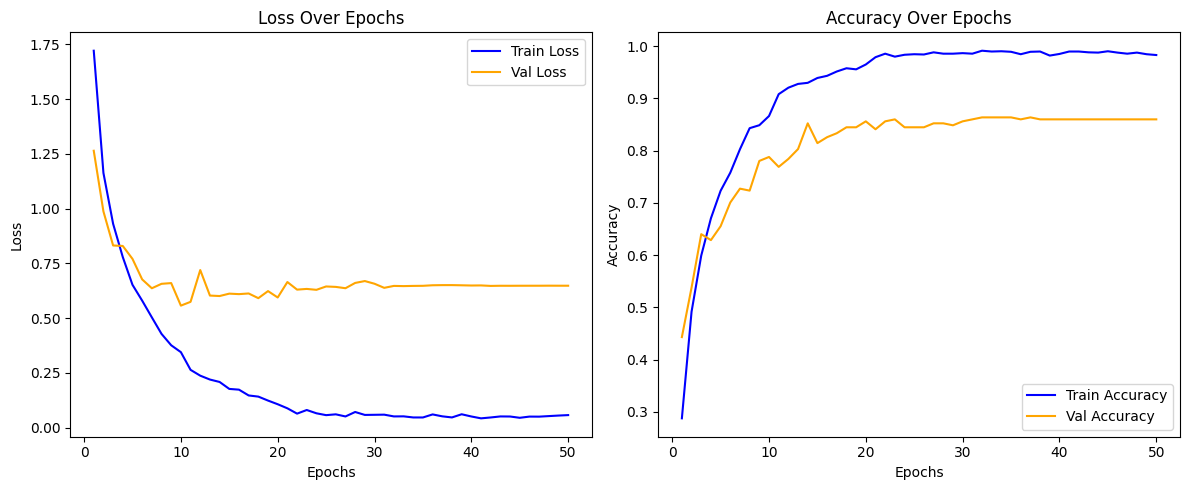

In [8]:
def plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies):
    # Convert all elements to CPU floats if they are tensors
    train_losses = [t.cpu().item() if hasattr(t, 'device') else t for t in train_losses]
    train_accuracies = [t.cpu().item() if hasattr(t, 'device') else t for t in train_accuracies]
    val_losses = [t.cpu().item() if hasattr(t, 'device') else t for t in val_losses]
    val_accuracies = [t.cpu().item() if hasattr(t, 'device') else t for t in val_accuracies]

    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Plot Losses
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss', color='b')
    plt.plot(epochs, val_losses, label='Val Loss', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Over Epochs')
    plt.legend()

    # Plot Accuracies
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy', color='b')
    plt.plot(epochs, val_accuracies, label='Val Accuracy', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Example call after training
plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies)

### Fine-tuned Swin3D Toledo test:

Looking at the various epochs, we'll use epoch 5 (file checkpoint_4)

In [9]:
#model = torch.load('checkpoints/Swin3d_fine_tune/checkpoint_4.pt',weights_only=False)
model.eval()

Swin3D_fine_tune(
  (swin): SwinTransformer3d(
    (patch_embed): PatchEmbed3d(
      (proj): Conv3d(3, 96, kernel_size=(2, 4, 4), stride=(2, 4, 4))
      (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (features): Sequential(
      (0): Sequential(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (attn): ShiftedWindowAttention3d(
            (qkv): Linear(in_features=96, out_features=288, bias=True)
            (proj): Linear(in_features=96, out_features=96, bias=True)
          )
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
          (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (mlp): MLP(
            (0): Linear(in_features=96, out_features=384, bias=True)
            (1): GELU(approximate='none')
            (2): Dropout(p=0.0, inplace=False)
            (3): Linear(in_features=384, out_features=96, bia

In [10]:
num_epochs = 1
for epoch in range(num_epochs):
    # Validation loop
    model.eval()
    val_loss = 0.0
    val_accuracy = 0.0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for videos, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            videos, labels = videos.cuda(), labels.cuda()

            # Forward pass
            logits = model(videos)

            # Compute the loss
            loss = criterion(logits, labels)

            # Track loss and accuracy
            val_loss += loss.item()
            val_accuracy += accuracy_metric(logits, labels)

            # Collect predictions and labels
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss /= len(val_loader)
    val_accuracy /= len(val_loader)

    print(f"Validation - Loss: {val_loss:.4f} - Accuracy: {val_accuracy:.4f}")

    # Compute metrics
    cm = confusion_matrix(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, digits=4)

    print("\nConfusion Matrix:\n", cm)
    print("\nClassification Report:\n", report)

Epoch 1/1: 100%|██████████| 33/33 [00:50<00:00,  1.52s/it]

Validation - Loss: 0.6479 - Accuracy: 0.8598

Confusion Matrix:
 [[18  0  1  0  0  1  0]
 [ 0 17  2  0  0  0  0]
 [ 2  2 61  5  1  1  0]
 [ 0  0  0 56  3  2  0]
 [ 0  0  0  2 23  0  6]
 [ 2  0  1  0  0 26  0]
 [ 0  0  1  2  3  0 20]]

Classification Report:
               precision    recall  f1-score   support

           0     0.8182    0.9000    0.8571        20
           1     0.8947    0.8947    0.8947        19
           2     0.9242    0.8472    0.8841        72
           3     0.8615    0.9180    0.8889        61
           4     0.7667    0.7419    0.7541        31
           5     0.8667    0.8966    0.8814        29
           6     0.7692    0.7692    0.7692        26

    accuracy                         0.8566       258
   macro avg     0.8430    0.8525    0.8471       258
weighted avg     0.8580    0.8566    0.8564       258



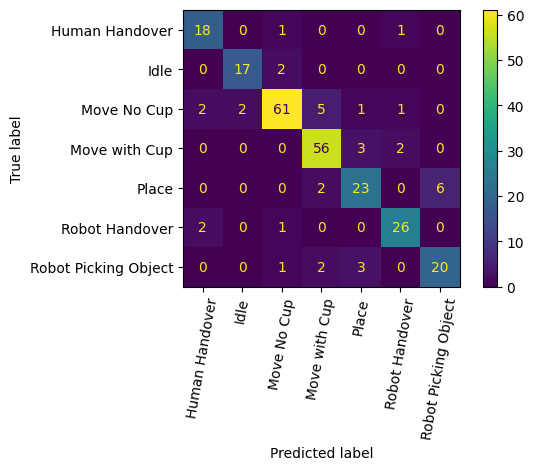

In [12]:
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Human Handover', 'Idle', 'Move No Cup','Move with Cup','Place','Robot Handover','Robot Picking Object'])
disp.plot()
plt.xticks(rotation=80)
plt.tight_layout()
plt.show()